# Optimization of Random Forest classifier

In the following, we evaluate different versions of the Rhapsody classifier, through 10-fold cross-validation over the Integrated Dataset, in order to find optimal parameters. More specifically, we considered:
* different subsets of the training dataset
* different subsets of features
* different classifier's hyperparameters.

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob
from prody import LOGGER

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.family': 'Arial'})

In [3]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

## Importing the training dataset

The Integrated Dataset used for training is available as a NumPy structured array containing all precomputed features, as well as true labels and other info (e.g. PDB lengths).

The Integrated Dataset has been built by merging 7 publicly available datasets of labelled human missense variants (HumVar, ExoVar, predictSNP, VariBench, SwissVar, Humsavar, ClinVar). Variants with discordant interpretations between datasets have `true_label = -1`. See `Training_Dataset` tutorial for more details.

In [4]:
# please make sure to extract the data folder beforehand
ID = np.load('../00-Training_Dataset/local/data/precomputed_features-ID.npy')

In [5]:
# array structure
print(ID.dtype.names)

('SAV_coords', 'Uniprot2PDB', 'PDB_length', 'true_label', 'ANM_MSF-chain', 'ANM_MSF-reduced', 'ANM_MSF-sliced', 'ANM_effectiveness-chain', 'ANM_effectiveness-reduced', 'ANM_effectiveness-sliced', 'ANM_sensitivity-chain', 'ANM_sensitivity-reduced', 'ANM_sensitivity-sliced', 'BLOSUM', 'Delta_PSIC', 'Delta_SASA', 'EVmut-DeltaE_epist', 'EVmut-DeltaE_indep', 'EVmut-mut_aa_freq', 'EVmut-wt_aa_cons', 'GNM_MSF-chain', 'GNM_MSF-reduced', 'GNM_MSF-sliced', 'GNM_effectiveness-chain', 'GNM_effectiveness-reduced', 'GNM_effectiveness-sliced', 'GNM_sensitivity-chain', 'GNM_sensitivity-reduced', 'GNM_sensitivity-sliced', 'SASA', 'SASA_in_complex', 'entropy', 'ranked_MI', 'stiffness-chain', 'stiffness-reduced', 'stiffness-sliced', 'wt_PSIC')


In [6]:
# each entry can be accessed by indexing
ID[0]

('A0AV02 181 R C', 'Unable to map SAV to PDB', 0, 0, nan, nan, nan, nan, nan, nan, nan, nan, nan, -3., 3.805, nan, -8.3871, -7.7763, 0., 0.5921, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.217494, 0.6424731, nan, nan, nan, -1.217)

In [7]:
# size of the training dataset
len(ID)

91697

In [8]:
# let's discard SAVs with unknown significance (true_label == -1)
ID = ID[ID['true_label'] != -1]
len(ID)

87726

In [9]:
# number of entries with an associated PDB structure
len(ID[ ID['PDB_length' ] > 0])

27655

## Dataset filtering based on ClinVar review status

Each entry in the ClinVar dataset is assigned with a review "star", between 0 to 4, which indicates the quality of the clinical interpretation, based on consensus between sources. 

We start by analyzing the impact on the classifier's accuracy of increasingly strict constraints on SAVs quality (at least for SAVs found in the ClinVar database).

For this analysis, we will make a couple of reasonable assumptions that will be justified *a posteriori* in the next sections, for instance:
* we will discard SAVs mapped to PDB structures smaller than 150 residues
* we will select a specific set of features (see below)

In [10]:
ID_SAVs_info = np.load('../00-Training_Dataset/local/data/Integrated_Dataset-SAVs.npy')
ID_SAVs_info.dtype

dtype([('SAV_coords', '<U50'), ('true_label', '<i2'), ('datasets', '<U100'), ('ClinVar_review_star', '<i2')])

In [11]:
from collections import Counter

count = Counter(ID_SAVs_info['ClinVar_review_star'])

print('review star   n. SAVs')
for star in range(5):
    print(f'{star:>11} {count[star]:>9}')
    
print(f'SAVs without ClinVar review star: {count[-1]}')

review star   n. SAVs
          0      9752
          1      5324
          2      5182
          3       548
          4         8
SAVs without ClinVar review star: 73691


In [12]:
ClinVar_review_stars = {s['SAV_coords']: s['ClinVar_review_star'] for s in ID_SAVs_info}

In [13]:
featset = rd.DEFAULT_FEATSETS['full']
featset

['wt_PSIC',
 'Delta_PSIC',
 'SASA',
 'ANM_MSF-chain',
 'ANM_effectiveness-chain',
 'ANM_sensitivity-chain',
 'stiffness-chain',
 'entropy',
 'ranked_MI',
 'BLOSUM']

In [14]:
if not os.path.isdir('local'):
    os.mkdir('local')

In [15]:
if not os.path.isdir('local/results'):
    os.mkdir('local/results')

In [16]:
if os.path.isfile('local/results/CV_summaries_1.pkl'):
    CV_summaries_1 = pickle.load(open('local/results/CV_summaries_1.pkl', 'rb'))
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')   
else:
    # let's consider only PDBs larger than 150 residues
    ID_150 = ID[ ID['PDB_length'] >= 150 ]

    # cycle of cross-validation tests after excluding ClinVar SAVs 
    # with increasing reliability ranking (= review star) from training dataset

    CV_summaries_1 = {}
    
    LOGGER.start('local/results/RF_optimization_1.log')

    for star in range(6):
        
        # we exclude SAVs with review star smaller than given value 
        # (if ClinVar's rating is found)
        ID_subset = ID_150[ [ClinVar_review_stars[SAV]==-1 or 
                             ClinVar_review_stars[SAV] >= star 
                             for SAV in ID_150['SAV_coords']] ]

        LOGGER.info(f'REVIEW STAR: {star:1}')
        LOGGER.info(f'SAVs removed from ID: {len(ID_150)-len(ID_subset):4}')

        # create folder
        folder = f'local/results/review_star-{star}'
        os.mkdir(folder)
        
        # run cross-validation
        sel = ['SAV_coords', 'true_label'] + featset
        ID_subset = ID_subset[sel]
        CV_summaries_1[star] = rd.RandomForestCV(ID_subset)

        # move figures into folder
        for file in glob('*png'):
            os.rename(file, os.path.join(folder, file))

        LOGGER.info('')

    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries_1, open('local/results/CV_summaries_1.pkl', 'wb'))

    LOGGER.close('local/results/RF_optimization_1.log')

A pickle containing precomputed results have been found.
Please delete it if you wish to run the analysis again.


In [17]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

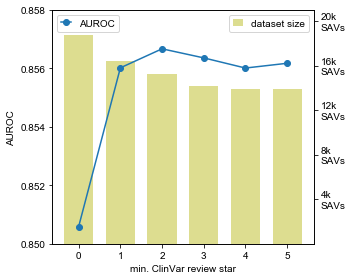

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

x = range(6)

y = np.array([CV_summaries_1[n]['mean AUROC'] for n in x])
ax.plot(x, y, '-o', label='AUROC')

ax2 = ax.twinx()
hb = ax2.bar(x, [CV_summaries_1[n]['dataset size'] for n in x], 
             color = 'C8', width=.7, alpha=0.5, label='dataset size')
ax2.set_zorder(ax.get_zorder()-1)
ax.patch.set_visible(False)

ax.set_xlabel('min. ClinVar review star')
ax.set_ylabel('AUROC')
ax.set_ylim((.85, .858))
ax.locator_params(nbins=5, axis='y')

ax2.set_ylim((0, 21000))
ax2.set_yticks(range(4000, 20001, 4000))
ax2.set_yticklabels(['4k\nSAVs', '8k\nSAVs', '12k\nSAVs', '16k\nSAVs', '20k\nSAVs'])

ax.legend(handlelength=1, loc='upper left')
ax2.legend(handlelength=1)

plt.tight_layout()
fig.savefig('local/figures/accuracy_vs_review_star.png', dpi=300)


Based on these results, we will exclude from our training dataset SAVs with a ClinVar review star = 0.

In [19]:
original_ID = ID

ID = ID[ [ClinVar_review_stars[SAV] != 0 for SAV in ID['SAV_coords']] ]
print('original dataset size:', len(original_ID))
print('filtered dataset size:', len(ID))

original dataset size: 87726
filtered dataset size: 80215


## 2. Cross-validation with various classification schemes

Next, we test different combinations of features and training datasets, specifically:

* different subsets of the training dataset, obtained by setting a minimum PDB structure size
* 4 different feature sets, including one reproducing version 1 of the method (RAPSODY)
* **GNM** vs **ANM** features
* ENM features computed with and without the inclusion of *enviromental* effects (**chain**, **reduced** or **sliced** models), i.e. the presence of other chains in the PDB structure

In [20]:
# this cell requires a few hours to complete

if os.path.isfile('local/results/CV_summaries_2.pkl'):
    CV_summaries_2 = pickle.load(open('local/results/CV_summaries_2.pkl', 'rb'))
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')
else:
    LOGGER.start('local/results/RF_optimization_2.log')
    CV_summaries_2 = {}
    
    for min_num_res in [1, 100, 150, 200, 300, 400, 500, 600]:
        # compute subset of the training dataset
        ID_subset = ID[ ID['PDB_length'] >= min_num_res ]
        
        # loop over different classification schemes
        for ENM in ['GNM', 'ANM']:
            for model in ['chain', 'reduced', 'sliced']:
                for version in ['full', 'reduced', 'EVmut', 'v1']:

                    # select feature set (+ true label)
                    if version == 'full':
                        featset = ['wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'entropy', 'ranked_MI', 'BLOSUM']
                    elif version == 'reduced':
                        featset = ['wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'BLOSUM']
                    elif version == 'EVmut':
                        # full classifier + EVmutation epistatic score
                        featset = ['wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   f'{ENM}_MSF-{model}',
                                   f'{ENM}_effectiveness-{model}',
                                   f'{ENM}_sensitivity-{model}',
                                   f'stiffness-{model}',
                                   'entropy', 'ranked_MI', 'BLOSUM',
                                   'EVmut-DeltaE_epist']
                    elif version == 'v1' and ENM == 'GNM' and model == 'chain':
                        # classifier as in version 1 of Rhapsody (RAPSODY)
                        # NB: RAPSODY used a combination of GNM/ANM features, which
                        # we reproduce here for the sake of comparison
                        featset = ['wt_PSIC', 'Delta_PSIC', 'SASA', 
                                   'GNM_MSF-chain', 
                                   'ANM_effectiveness-chain', 
                                   'ANM_sensitivity-chain',
                                   'stiffness-chain']
                    else:
                        continue

                    if version == 'v1':
                        scheme = f'{min_num_res}-v1'
                    else:
                        scheme = f'{min_num_res}-{ENM}-{model}-{version}'
                        
                    LOGGER.info(f'CLASSIFICATION SCHEME: {scheme}')

                    # create folder
                    folder = f'local/results/clsf_scheme-{scheme}'
                    os.mkdir(folder)
                    
                    # run cross-validation
                    sel = ['SAV_coords', 'true_label'] + featset
                    CV_summaries_2[scheme] = rd.RandomForestCV(ID_subset[sel])

                    # move figures into folder
                    for file in glob('*png'):
                        os.rename(file, os.path.join(folder, file))
                    
                    LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries_2, open('local/results/CV_summaries_2.pkl', 'wb'))

    LOGGER.close('local/results/RF_optimization_2.log')

A pickle containing precomputed results have been found.
Please delete it if you wish to run the analysis again.


### Figures & summary

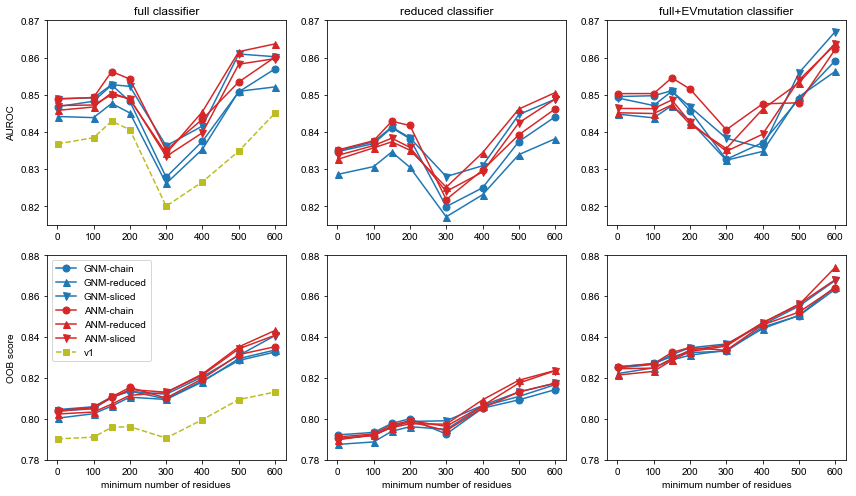

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

ax[0,0].set_title('full classifier')
ax[0,1].set_title('reduced classifier')
ax[0,2].set_title('full+EVmutation classifier')
ax[0,0].set_ylabel('AUROC')
ax[1,0].set_ylabel('OOB score')
for j in range(3):
    ax[0,j].set_ylim([.815, .87])
    ax[1,j].set_ylim([.78, .88])
    ax[1,j].set_xlabel('minimum number of residues')
   
x = [1, 100, 150, 200, 300, 400, 500, 600]
for ENM in ['GNM', 'ANM']:
    col = 'C0' if ENM=='GNM' else 'C3'
    for model in ['chain', 'reduced', 'sliced']:
        if model == 'chain':
            mk = 'o'
        elif model == 'reduced':
            mk = '^'
        else:
            mk = 'v'
        for i, version in enumerate(['full', 'reduced', 'EVmut']):
            scheme = f'{ENM}-{model}-{version}'
            AUC = [CV_summaries_2[f'{n}-{scheme}']['mean AUROC'] for n in x]
            OOB = [CV_summaries_2[f'{n}-{scheme}']['mean OOB score'] for n in x]
            ax[0,i].plot(x, AUC, col+mk+'-', ms=7)
            ax[1,i].plot(x, OOB, col+mk+'-', ms=7,label=f'{ENM}-{model}')

AUC = [CV_summaries_2[f'{n}-v1']['mean AUROC'] for n in x]
OOB = [CV_summaries_2[f'{n}-v1']['mean OOB score'] for n in x]
ax[0,0].plot(x, AUC, 'C8s--')
ax[1,0].plot(x, OOB, 'C8s--', label='v1')

ax[1,0].legend()

plt.tight_layout()
fig.savefig('local/figures/performances_comparison.png', dpi=300)

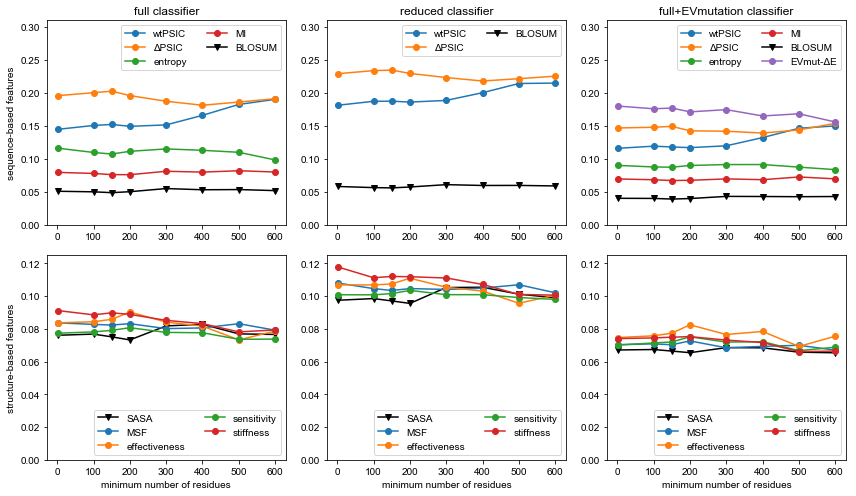

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
fig.subplots_adjust(wspace=0.2)

featsets = {}
featsets['full'] = ['wtPSIC', 'ΔPSIC', 'SASA', 'MSF', 
                    'effectiveness', 'sensitivity', 'stiffness', 
                    'entropy', 'MI', 'BLOSUM']
featsets['reduced'] = ['wtPSIC', 'ΔPSIC', 'SASA', 'MSF', 
                       'effectiveness', 'sensitivity', 'stiffness', 'BLOSUM']
featsets['EVmut'] = featsets['full'] + ['EVmut-ΔE',]
SEQ_feats = ['wtPSIC', 'ΔPSIC', 'BLOSUM', 'entropy', 'MI', 'EVmut-ΔE']

ax[0,0].set_title('full classifier')
ax[0,1].set_title('reduced classifier')
ax[0,2].set_title('full+EVmutation classifier')
ax[0,0].set_ylabel('sequence-based features')
ax[1,0].set_ylabel('structure-based features')
for j in range(3):
    ax[0,j].set_ylim([0, .31])
    ax[1,j].set_ylim([0, .125])
    ax[1,j].set_xlabel('minimum number of residues')

x = [1, 100, 150, 200, 300, 400, 500, 600]

for i, (version, featset) in enumerate(featsets.items()):
    for j,f in enumerate(featset):
        ss = [CV_summaries_2[f'{n}-ANM-chain-{version}']['feat. importance'][j] for n in x]
        if f in ['BLOSUM', 'SASA']:
            m = 'kv-'
        elif f == 'EVmut-DeltaE':
            m = '^-'
        else:
            m = 'o-'
        if f in SEQ_feats:
            ax[0,i].plot(x, ss, m, label=f)
        else:
            ax[1,i].plot(x, ss, m, label=f)
            
for a in ax[0]:
    a.legend(loc='upper right', ncol=2)
for a in ax[1]:
    a.legend(loc='lower right', ncol=2)

plt.tight_layout()
fig.savefig('local/figures/feat_imp_comparison.png', dpi=300)

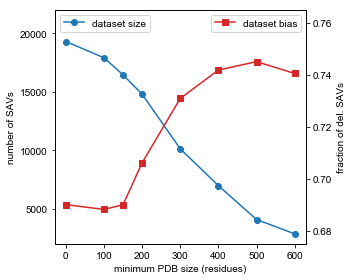

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

x = [1, 100, 150, 200, 300, 400, 500, 600]

y = np.array([CV_summaries_2[f'{n}-ANM-chain-full']['dataset size'] for n in x])
h1 = ax.plot(x, y, '-o', label='dataset size')

ax2 = ax.twinx()
h2 = ax2.plot(x, [CV_summaries_2[f'{n}-ANM-chain-full']['dataset bias'] for n in x], 
              'C3-s', label='dataset bias')

ax.set_xlabel('minimum PDB size (residues)')
ax.set_ylabel('number of SAVs')
ax2.set_ylabel('fraction of del. SAVs')

ax.set_ylim((2000, 22000))
ax2.set_ylim((.675, .765))

ax.locator_params(nbins=5, axis='y')
ax2.locator_params(nbins=7, axis='y')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
fig.savefig('local/figures/dataset_size_vs_bias.png', dpi=300)

## 3. Hyperparameter optimization

The main hyperparameters of a Random Forest classifier that can be tuned are:

* the number of "trees" in the "forest"
* the maximum number of features used for training a single tree.

Based on the previous analysis, we will perform hyperparameter optimization only on the `'150-ANM-chain-v2'` classification scheme.

In [24]:
# this cell requires ~3 hours to complete

if os.path.isfile('local/results/CV_summaries_3.pkl'):
    CV_summaries_3 = pickle.load(open('local/results/CV_summaries_3.pkl', 'rb'))
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')
else:   
    LOGGER.start('local/results/RF_optimization_3.log')
    CV_summaries_3 = {}
    
    ID_subset = ID[ ID['PDB_length'] >= 150 ]
    sel = ['SAV_coords', 'true_label'] + rd.DEFAULT_FEATSETS['full']
    ID_subset = ID_subset[sel]
    
    for n_trees in [100, 500, 1000, 1500, 2000]:
        for max_nfeats in range(2, len(featset)-1):

            scheme = f'{n_trees}-{max_nfeats}'

            LOGGER.info(f'PARAMETERS: {scheme}')

            # create folder
            folder = f'local/results/hyp_optimization-{scheme}'
            os.mkdir(folder)

            # run cross-validation
            CV_summaries_3[scheme] = rd.RandomForestCV(ID_subset, 
                                                       n_estimators=n_trees, 
                                                       max_features=max_nfeats)

            # move figures into folder
            for file in glob('*png'):
                os.rename(file, os.path.join(folder, file))

            LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(CV_summaries_3, open('local/results/CV_summaries_3.pkl', 'wb'))

    LOGGER.close('local/results/RF_optimization_3.log')

A pickle containing precomputed results have been found.
Please delete it if you wish to run the analysis again.


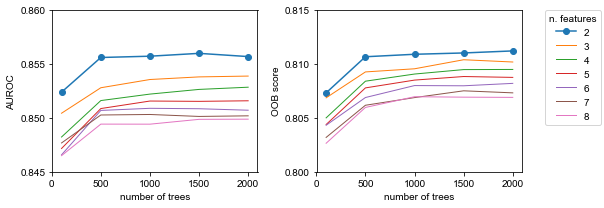

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,3))
fig.subplots_adjust(wspace=0.2)

x = [100, 500, 1000, 1500, 2000]

for max_nfeats in range(2, len(rd.DEFAULT_FEATSETS['full'])-1):

    lw = 1.5  if max_nfeats==2 else 1
    mk = '-o' if max_nfeats==2 else '-'
    
    y = np.array([CV_summaries_3[f'{n}-{max_nfeats}']['mean AUROC'] for n in x])
    ax1.plot(x, y, mk, lw=lw)
    
    y = np.array([CV_summaries_3[f'{n}-{max_nfeats}']['mean OOB score'] for n in x])
    ax2.plot(x, y, mk, lw=lw, label=f'{max_nfeats}')

ax1.set_xlabel('number of trees')
ax1.set_ylabel('AUROC')
ax2.set_xlabel('number of trees')
ax2.set_ylabel('OOB score')

ax1.set_ylim((0.845, 0.86))
ax2.set_ylim((0.80, 0.815))
ax1.locator_params(nbins=5, axis='y')
ax2.locator_params(nbins=5, axis='y')

lgd = fig.legend(title='n. features', bbox_to_anchor=(1, 0.94), 
                 loc='upper left', ncol=1)
plt.tight_layout()
fig.savefig('local/figures/hyp_optimization.png', bbox_extra_artists=(lgd,), 
            bbox_inches='tight', dpi=300)

In [26]:
plt.rcParams.update(plt.rcParamsDefault)